In [1]:
import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from matplotlib import pylab as plt
import scipy.stats

In [2]:
import os, sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from project.data.make_steps import make_data_dict, step_detection

In [77]:
data_dict = make_data_dict('00010100_s001_t000')
steps = step_detection(data_dict, 'FP1')
step1 = steps[0]
data = data_dict['FP1'][step1[0]:step1[1] - 10000]
print(data)

[ 3.84556184e-05  3.67771529e-05  3.40305730e-05 ... -2.28846657e-05
 -2.33424290e-05 -2.05958491e-05]


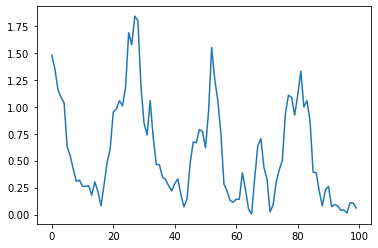

In [78]:
data = np.power(data[0:100],2) * np.power(10, 9)
plt.plot(data)
plt.show()

In [84]:
num_states = 7

initial_state_logits = np.zeros([num_states], dtype=np.float32) # uniform distribution

daily_change_prob = 0.3
transition_probs = daily_change_prob / (num_states-1) * np.ones(
    [num_states, num_states], dtype=np.float32)
np.fill_diagonal(transition_probs,
                 1-daily_change_prob)
transition_probs[0] = np.zeros(num_states)
transition_probs[0][0] = 1
transition_probs[-1] = np.flip(transition_probs[0])

print("Initial state logits:\n{}".format(initial_state_logits))
print("Transition matrix:\n{}".format(transition_probs))

Initial state logits:
[0. 0. 0. 0. 0. 0. 0.]
Transition matrix:
[[1.   0.   0.   0.   0.   0.   0.  ]
 [0.05 0.7  0.05 0.05 0.05 0.05 0.05]
 [0.05 0.05 0.7  0.05 0.05 0.05 0.05]
 [0.05 0.05 0.05 0.7  0.05 0.05 0.05]
 [0.05 0.05 0.05 0.05 0.7  0.05 0.05]
 [0.05 0.05 0.05 0.05 0.05 0.7  0.05]
 [0.   0.   0.   0.   0.   0.   1.  ]]


In [85]:
# Define variable to represent the unknown log rates.
trainable_log_rates = tf.Variable(
  np.log(np.mean(data)) + tf.random.normal([num_states]),
  name='log_rates')

hmm = tfd.HiddenMarkovModel(
  initial_distribution=tfd.Categorical(
      logits=initial_state_logits),
  transition_distribution=tfd.Categorical(probs=transition_probs),
  observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
  num_steps=len(data))

In [86]:
rate_prior = tfd.LogNormal(5, 5)

def log_prob():
    return (tf.reduce_sum(rate_prior.log_prob(tf.math.exp(trainable_log_rates))) + hmm.log_prob(data))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

@tf.function(autograph=False)
def train_op():
    with tf.GradientTape() as tape:
        neg_log_prob = -log_prob()
    grads = tape.gradient(neg_log_prob, [trainable_log_rates])[0]
    optimizer.apply_gradients([(grads, trainable_log_rates)])
    return neg_log_prob, tf.math.exp(trainable_log_rates)

In [88]:
for step in range(41):
    loss, rates = [t.numpy() for t in train_op()]
    if step % 2 == 0:
        print("step {}: log prob {} rates {}".format(step, -loss, rates))

print("Inferred rates: {}".format(rates))

step 0: log prob -63.73637771606445 rates [5.6866843e-01 5.9560807e-07 2.0529204e-07 1.2085600e-07 5.0987148e-07
 1.3849233e-07 4.2587118e-08]
step 2: log prob -63.64155197143555 rates [5.6866544e-01 5.4173665e-07 1.8812354e-07 1.1132173e-07 4.6415826e-07
 1.2739095e-07 3.9723659e-08]
step 4: log prob -63.54981994628906 rates [5.68662465e-01 4.93300547e-07 1.72602398e-07 1.02666917e-07
 4.23033441e-07 1.17324575e-07 3.70981326e-08]
step 6: log prob -63.46104431152344 rates [5.6866318e-01 4.4970605e-07 1.5855511e-07 9.4801720e-08 3.8599671e-07
 1.0818666e-07 3.4688124e-08]
step 8: log prob -63.375160217285156 rates [5.6866604e-01 4.1042807e-07 1.4582757e-07 8.7646157e-08 3.5260655e-07
 9.9882222e-08 3.2473739e-08]
step 10: log prob -63.29207229614258 rates [5.6866711e-01 3.7500280e-07 1.3428323e-07 8.1129208e-08 3.2247235e-07
 9.2327163e-08 3.0436919e-08]
step 12: log prob -63.211708068847656 rates [5.6866533e-01 3.4301934e-07 1.2380062e-07 7.5187401e-08 2.9524833e-07
 8.5446175e-08 2.8